In [1]:
import optuna

In [2]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = load_boston()

In [4]:
df_feat = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

In [5]:
df_feat.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [6]:
df_feat.var()

CRIM          73.986578
ZN           543.936814
INDUS         47.064442
CHAS           0.064513
NOX            0.013428
RM             0.493671
AGE          792.358399
DIS            4.434015
RAD           75.816366
TAX        28404.759488
PTRATIO        4.686989
B           8334.752263
LSTAT         50.994760
dtype: float64

## 線形モデルでフィッティング

適当にパラメータを決め打ちにして線形モデル `Ridge` 回帰でフィッティング。

Ridge 回帰の目的関数は以下の通り. ここで $N$ はデータの数, $\phi_n \in \mathbb{R}^M$ は $n$ 番目のデータの $M$ 次元特徴ベクトル.

$$
\min_{w} = \sum_{n=1}^{N} (\phi_n^{T} w - t_{n})^2 + \alpha \| w \|^2
$$

アルファの値が大きいほど重みに対するペナルティが大きくなり、ゼロに近くなる。

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

Fold=5 の Out of Fold をやる。パラメータ alpha は一旦 `1` で決め打ちにする。

In [8]:
fold = KFold(n_splits=5, random_state=19, shuffle=True)

models = []
oof_pred_ridge = np.zeros_like(y, dtype=np.float32)

X = df_feat.values
for idx_train, idx_valid in fold.split(X, y):
    x_train, y_train = X[idx_train], y[idx_train]
    x_valid, y_valid = X[idx_valid], y[idx_valid]
    
    clf = Ridge(alpha=1.)
    clf.fit(x_train, y_train)
    oof_pred_ridge[idx_valid] = clf.predict(x_valid)
    models.append(clf)

In [9]:
rmse = mean_squared_error(y, oof_pred_ridge) ** .5
print(rmse)

4.935198271243945


Text(0.5, 1.0, 'RMSE 4.935')

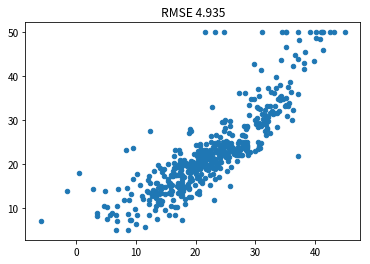

In [10]:
plt.scatter(oof_pred_ridge, y, s=20)
plt.title(f'RMSE {rmse:.3f}')

重要変数の可視化。

各 fold での重要度を取ってきてその分布を見る。

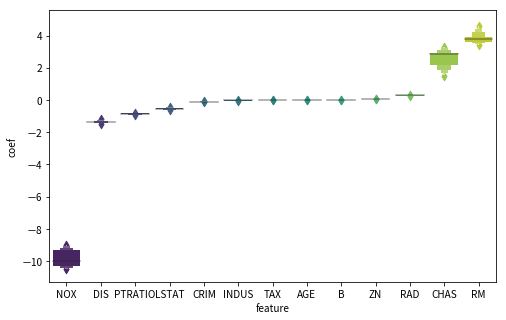

In [11]:
df_coef = pd.DataFrame()
for i, clf in enumerate(models):
    _df_i = pd.DataFrame(clf.coef_, index=df_feat.columns, columns=['coef']).reset_index()
    _df_i = _df_i.rename(columns={ 'index': 'feature' })
    _df_i['fold'] = i
    df_coef = pd.concat([df_coef, _df_i])

order = df_coef.groupby('feature').mean().sort_values('coef').index

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxenplot(data=df_coef, x='feature', y='coef', ax=ax, palette='viridis', order=order)

## Optuna でパラメータ最適化

optuna を使うときに必要なのは, 実験条件を作る trial オブジェクトを受け取って何かしらの評価尺度を返す `objective` 関数。

なにかパラメータを変えたい時には trial からそのパラメータを生成する。
今回は `sugget_loguniform` でログスケールに対して一様な分布からアルファを生成しています。

In [12]:
def train_ridge(params=None):
    fold = KFold(n_splits=5, random_state=19, shuffle=True)
    models = []
    oof_pred_ridge = np.zeros_like(y, dtype=np.float32)

    X = df_feat.values
    
    if params is None:
        params = {}
    
    for idx_train, idx_valid in fold.split(X, y):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = Ridge(**params)
        clf.fit(x_train, y_train)
        oof_pred_ridge[idx_valid] = clf.predict(x_valid)
        models.append(clf)
    return models, oof_pred_ridge

In [13]:
def objective(trial):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 1e2)
    }
    _, oof = train_ridge(params)
    return mean_squared_error(y, oof) ** .5

In [14]:
study = optuna.create_study()
study.optimize(objective, n_trials=300)

[I 2019-03-29 14:18:15,728] Finished a trial resulted in value: 4.980906680384071. Current best value is 4.980906680384071 with parameters: {'alpha': 8.340235447389471}.
[I 2019-03-29 14:18:15,743] Finished a trial resulted in value: 4.921484368444778. Current best value is 4.921484368444778 with parameters: {'alpha': 0.05214891175399747}.
[I 2019-03-29 14:18:15,749] Finished a trial resulted in value: 4.940411661208272. Current best value is 4.921484368444778 with parameters: {'alpha': 0.05214891175399747}.
[I 2019-03-29 14:18:15,759] Finished a trial resulted in value: 4.96607074887637. Current best value is 4.921484368444778 with parameters: {'alpha': 0.05214891175399747}.
[I 2019-03-29 14:18:15,766] Finished a trial resulted in value: 5.084354014765078. Current best value is 4.921484368444778 with parameters: {'alpha': 0.05214891175399747}.
[I 2019-03-29 14:18:15,772] Finished a trial resulted in value: 4.923187284841404. Current best value is 4.921484368444778 with parameters: {'a

[I 2019-03-29 14:18:16,169] Finished a trial resulted in value: 4.921325674591576. Current best value is 4.921318659337557 with parameters: {'alpha': 0.11369944693734681}.
[I 2019-03-29 14:18:16,181] Finished a trial resulted in value: 4.990466903886827. Current best value is 4.921318659337557 with parameters: {'alpha': 0.11369944693734681}.
[I 2019-03-29 14:18:16,192] Finished a trial resulted in value: 4.934575085627641. Current best value is 4.921318659337557 with parameters: {'alpha': 0.11369944693734681}.
[I 2019-03-29 14:18:16,204] Finished a trial resulted in value: 4.923456952513759. Current best value is 4.921318659337557 with parameters: {'alpha': 0.11369944693734681}.
[I 2019-03-29 14:18:16,216] Finished a trial resulted in value: 4.970267267124835. Current best value is 4.921318659337557 with parameters: {'alpha': 0.11369944693734681}.
[I 2019-03-29 14:18:16,228] Finished a trial resulted in value: 4.921589154287405. Current best value is 4.921318659337557 with parameters: 

[I 2019-03-29 14:18:16,777] Finished a trial resulted in value: 4.921787035743494. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:16,793] Finished a trial resulted in value: 4.921628751295457. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:16,811] Finished a trial resulted in value: 4.991881898744797. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:16,827] Finished a trial resulted in value: 4.986338052902898. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:16,841] Finished a trial resulted in value: 4.97205189492073. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:16,889] Finished a trial resulted in value: 4.950265469728399. Current best value is 4.92131693712849 with parameters: {'alpha': 0.

[I 2019-03-29 14:18:17,520] Finished a trial resulted in value: 4.921324931895991. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:17,536] Finished a trial resulted in value: 4.970914863494456. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:17,551] Finished a trial resulted in value: 4.929448353638977. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:17,567] Finished a trial resulted in value: 4.921316939645985. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:17,583] Finished a trial resulted in value: 4.922582577286981. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:17,601] Finished a trial resulted in value: 4.921521687238505. Current best value is 4.92131693712849 with parameters: {'alpha': 0

[I 2019-03-29 14:18:18,364] Finished a trial resulted in value: 4.92158231783005. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:18,382] Finished a trial resulted in value: 4.921317199127772. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:18,401] Finished a trial resulted in value: 4.921750314349234. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:18,421] Finished a trial resulted in value: 4.921317341845897. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:18,442] Finished a trial resulted in value: 4.921422266690454. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:18,462] Finished a trial resulted in value: 4.922578207014606. Current best value is 4.92131693712849 with parameters: {'alpha': 0.

[I 2019-03-29 14:18:19,367] Finished a trial resulted in value: 4.925454173748729. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:19,390] Finished a trial resulted in value: 4.98584142279855. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:19,414] Finished a trial resulted in value: 4.921849604999243. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:19,437] Finished a trial resulted in value: 4.934007422393739. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:19,458] Finished a trial resulted in value: 4.921359378917033. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:19,479] Finished a trial resulted in value: 4.921552656373014. Current best value is 4.92131693712849 with parameters: {'alpha': 0.

[I 2019-03-29 14:18:20,504] Finished a trial resulted in value: 4.921810450207035. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:20,530] Finished a trial resulted in value: 4.921330161134051. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:20,557] Finished a trial resulted in value: 4.921492619884016. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:20,581] Finished a trial resulted in value: 4.921570991878378. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:20,604] Finished a trial resulted in value: 4.921700705616225. Current best value is 4.92131693712849 with parameters: {'alpha': 0.1077118136620747}.
[I 2019-03-29 14:18:20,628] Finished a trial resulted in value: 4.921466093808359. Current best value is 4.92131693712849 with parameters: {'alpha': 0

In [15]:
df_trial = study.trials_dataframe().sort_values('value')

In [16]:
df_trial.head()

trial_id                state     value             datetime_start  \
                                                                         
75        75  TrialState.COMPLETE  4.921317 2019-03-29 14:18:16.470097   
145      145  TrialState.COMPLETE  4.921317 2019-03-29 14:18:17.553034   
224      224  TrialState.COMPLETE  4.921317 2019-03-29 14:18:19.042893   
191      191  TrialState.COMPLETE  4.921317 2019-03-29 14:18:18.365386   
103      103  TrialState.COMPLETE  4.921317 2019-03-29 14:18:16.935493   

             datetime_complete    params  
                                   alpha  
75  2019-03-29 14:18:16.477816  0.107712  
145 2019-03-29 14:18:17.560874  0.106764  
224 2019-03-29 14:18:19.052735  0.110169  
191 2019-03-29 14:18:18.374048  0.105268  
103 2019-03-29 14:18:16.943814  0.104944

もともとが 4.935 ぐらいだったので若干は良くなった?

In [17]:
study.best_params

{'alpha': 0.1077118136620747}

In [18]:
models, oof_pred_ridge = train_ridge(study.best_params)

Text(0.5, 1.0, 'さいてきなときの予測と正解ラベルの分布')

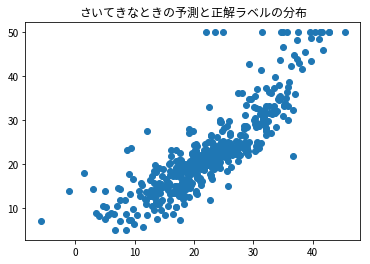

In [19]:
plt.scatter(oof_pred_ridge, y)
plt.title('さいてきなときの予測と正解ラベルの分布')

## おまけ

log スケーリングをするかしないかも入れてみる.

具体的にはターゲット変数を log 変換して fit して予測した後に exp で元に戻します。こうすると目的関数が対数正規分布の負の対数ゆうどを仮定することになるので、問題によってはよく当てはまったりします。

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
def train_ridge_with_scaling(X, y, params=None):
    fold = KFold(n_splits=5, random_state=19, shuffle=True)
    models = []
    oof_pred_ridge = np.zeros_like(y, dtype=np.float32)

    X = df_feat.values
    X = StandardScaler().fit_transform(X)
    
    use_log = params.pop('use_log', False)
    
    if use_log:
        y = np.log(y)
    
    if params is None:
        params = {}
    
    for idx_train, idx_valid in fold.split(X, y):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = Ridge(**params)
        clf.fit(x_train, y_train)
        
        pred = clf.predict(x_valid)
        if use_log:
            pred = np.exp(pred)
        oof_pred_ridge[idx_valid] = pred
        models.append(clf)
    return models, oof_pred_ridge

def objective(trial):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e2),
        'use_log': trial.suggest_categorical('use_log',[ True, False])
    }
    _, oof = train_ridge_with_scaling(X, y, params)
    return mean_squared_error(y, oof) ** .5

In [22]:
study = optuna.create_study()
study.optimize(objective, n_trials=300)

[I 2019-03-29 14:18:21,625] Finished a trial resulted in value: 4.922001418154811. Current best value is 4.922001418154811 with parameters: {'alpha': 0.0004443618510045301, 'use_log': False}.
[I 2019-03-29 14:18:21,660] Finished a trial resulted in value: 4.922002078730057. Current best value is 4.922001418154811 with parameters: {'alpha': 0.0004443618510045301, 'use_log': False}.
[I 2019-03-29 14:18:21,689] Finished a trial resulted in value: 4.922002089556629. Current best value is 4.922001418154811 with parameters: {'alpha': 0.0004443618510045301, 'use_log': False}.
[I 2019-03-29 14:18:21,705] Finished a trial resulted in value: 4.497114334757863. Current best value is 4.497114334757863 with parameters: {'alpha': 1.2545781278207186, 'use_log': True}.
[I 2019-03-29 14:18:21,721] Finished a trial resulted in value: 4.495877615233722. Current best value is 4.495877615233722 with parameters: {'alpha': 0.03141988726602105, 'use_log': True}.
[I 2019-03-29 14:18:21,731] Finished a trial re

[I 2019-03-29 14:18:22,072] Finished a trial resulted in value: 4.4958619615691. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,085] Finished a trial resulted in value: 4.49585579583528. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,096] Finished a trial resulted in value: 4.922002108583462. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,107] Finished a trial resulted in value: 4.4959041850427575. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,119] Finished a trial resulted in value: 4.4958560611944955. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,130] Finished a trial r

[I 2019-03-29 14:18:22,617] Finished a trial resulted in value: 4.49588806313763. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,631] Finished a trial resulted in value: 4.4958554991138415. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,645] Finished a trial resulted in value: 4.495859927596724. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,661] Finished a trial resulted in value: 4.4958555818263495. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,677] Finished a trial resulted in value: 4.921848799352995. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:22,693] Finished a trial

[I 2019-03-29 14:18:23,368] Finished a trial resulted in value: 4.495855742967723. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:23,385] Finished a trial resulted in value: 4.495855521627609. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:23,405] Finished a trial resulted in value: 4.922001027270849. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:23,423] Finished a trial resulted in value: 4.495857189532009. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:23,443] Finished a trial resulted in value: 4.495858418506158. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:23,462] Finished a trial 

[I 2019-03-29 14:18:24,299] Finished a trial resulted in value: 4.495855621600266. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:24,333] Finished a trial resulted in value: 4.495856306558813. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:24,359] Finished a trial resulted in value: 4.495855544522467. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:24,384] Finished a trial resulted in value: 4.9220013054371785. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:24,408] Finished a trial resulted in value: 4.4958554994552475. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:24,434] Finished a tria

[I 2019-03-29 14:18:25,463] Finished a trial resulted in value: 4.495855540420859. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:25,499] Finished a trial resulted in value: 4.495906599562349. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:25,531] Finished a trial resulted in value: 4.921997540983779. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:25,562] Finished a trial resulted in value: 4.495855523724981. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:25,592] Finished a trial resulted in value: 4.4958558820778975. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:25,622] Finished a trial

[I 2019-03-29 14:18:26,816] Finished a trial resulted in value: 4.4958572432605814. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:26,849] Finished a trial resulted in value: 4.495855650495252. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:26,882] Finished a trial resulted in value: 4.495855558425045. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:26,915] Finished a trial resulted in value: 4.922000737112573. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:26,949] Finished a trial resulted in value: 4.496446764326432. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:26,982] Finished a trial

[I 2019-03-29 14:18:28,373] Finished a trial resulted in value: 4.495855603321446. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:28,409] Finished a trial resulted in value: 4.609961292733322. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:28,448] Finished a trial resulted in value: 4.495855548885183. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:28,488] Finished a trial resulted in value: 4.922001933836668. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:28,527] Finished a trial resulted in value: 4.495855497961145. Current best value is 4.495855472085835 with parameters: {'alpha': 2.053858425791591e-05, 'use_log': True}.
[I 2019-03-29 14:18:28,566] Finished a trial 

In [23]:
study.trials_dataframe().sort_values('value').head()

trial_id                state     value             datetime_start  \
                                                                         
35        35  TrialState.COMPLETE  4.495855 2019-03-29 14:18:21.989085   
110      110  TrialState.COMPLETE  4.495855 2019-03-29 14:18:23.034630   
69        69  TrialState.COMPLETE  4.495855 2019-03-29 14:18:22.397878   
145      145  TrialState.COMPLETE  4.495855 2019-03-29 14:18:23.722384   
159      159  TrialState.COMPLETE  4.495855 2019-03-29 14:18:24.031231   

             datetime_complete    params          
                                   alpha use_log  
35  2019-03-29 14:18:21.996389  0.000021    True  
110 2019-03-29 14:18:23.043974  0.000034    True  
69  2019-03-29 14:18:22.406314  0.000035    True  
145 2019-03-29 14:18:23.735342  0.000034    True  
159 2019-03-29 14:18:24.044790  0.000016    True

ログスケールにしたほうが精度良さそうですね

In [24]:
models, oof_pred_ridge = train_ridge_with_scaling(X, y, study.best_params)

In [25]:
rmse = mean_squared_error(y, oof_pred_ridge) ** .5
print(rmse)

4.495855472085835


Text(0.5, 1.0, 'さいてきなときの予測と正解ラベルの分布')

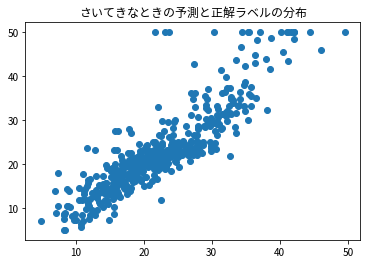

In [26]:
plt.scatter(oof_pred_ridge, y)
plt.title('さいてきなときの予測と正解ラベルの分布')

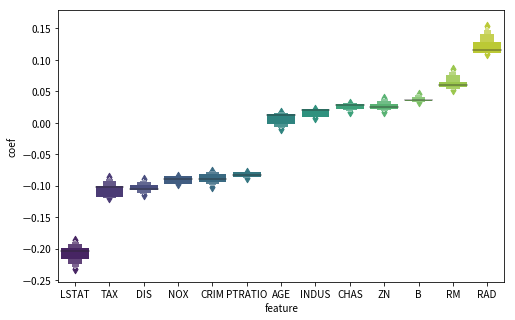

In [27]:
df_coef = pd.DataFrame()
for i, clf in enumerate(models):
    _df_i = pd.DataFrame(clf.coef_, index=df_feat.columns, columns=['coef']).reset_index()
    _df_i = _df_i.rename(columns={ 'index': 'feature' })
    _df_i['fold'] = i
    df_coef = pd.concat([df_coef, _df_i])

order = df_coef.groupby('feature').mean().sort_values('coef').index

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxenplot(data=df_coef, x='feature', y='coef', ax=ax, palette='viridis', order=order)

* 凄い大きい負の値だった NOX があまり重要視されなくなっている。おそらく元のモデルが上手く fitting できていなかったのが原因。(相関の高い変数の中から NOX だけを取り出していた可能性が高い

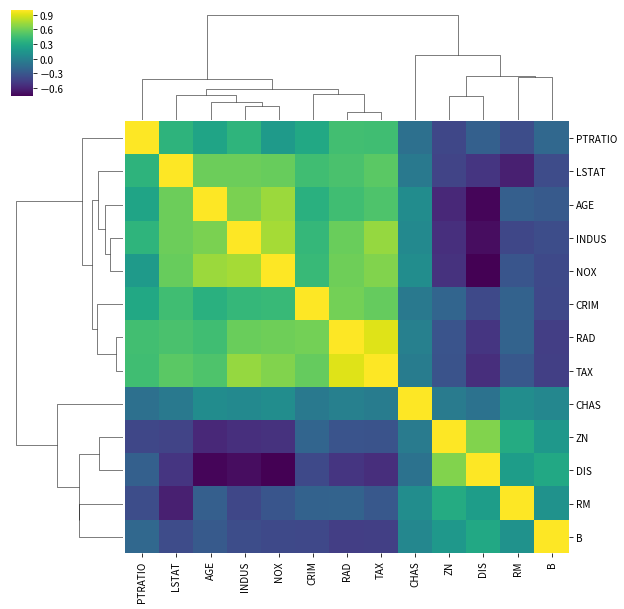

In [28]:
sns.clustermap(df_feat.corr(), cmap='viridis')